Import Required Libraries

In [34]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Define Data Transforms

In [36]:
# Preprocessing steps for training and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


Load the Dataset

In [38]:
data_dir = '/content/drive/MyDrive/Ml project/fruits'  # Change this if dataset is elsewhere

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True)
    for x in ['train', 'test']
}

class_names = image_datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Load Pre-trained ResNet50 Model



In [39]:
# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


Define Loss Function and Optimizer

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)


 Train the Model

In [41]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects.double() / len(image_datasets['train'])

    print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


Epoch 1/10
----------
Loss: 1.3982 Acc: 0.4370
Epoch 2/10
----------
Loss: 0.8779 Acc: 0.7297
Epoch 3/10
----------
Loss: 0.6169 Acc: 0.8516
Epoch 4/10
----------
Loss: 0.4907 Acc: 0.8984
Epoch 5/10
----------
Loss: 0.4465 Acc: 0.8862
Epoch 6/10
----------
Loss: 0.4333 Acc: 0.8780
Epoch 7/10
----------
Loss: 0.3335 Acc: 0.9268
Epoch 8/10
----------
Loss: 0.3280 Acc: 0.9187
Epoch 9/10
----------
Loss: 0.2941 Acc: 0.9309
Epoch 10/10
----------
Loss: 0.2935 Acc: 0.9228


Evaluate on Test Set

In [42]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 78.00%


Predictions on Test Images

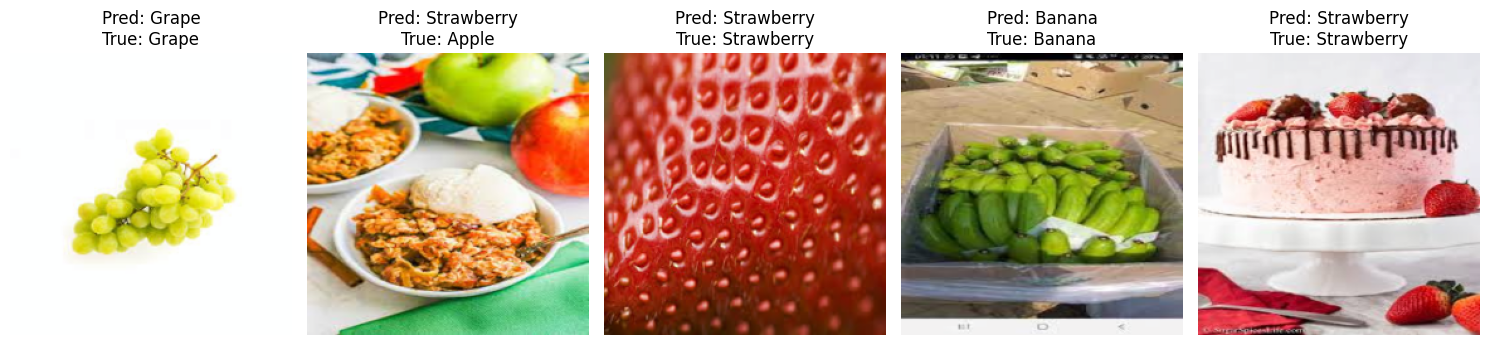

In [46]:
import numpy as np

def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean  # Unnormalize
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Show predictions
model.eval()
data_iter = iter(dataloaders['test'])
images, labels = next(data_iter)
images = images[:5]  # show first 5
labels = labels[:5]

outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(15, 5))
for i in range(len(images)):
    plt.subplot(1, 5, i+1)
    imshow(images[i].cpu(), title=f'Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}')
plt.tight_layout()
plt.show()
